# Statistical Analysis of Human-LLM Programming Dialogues

This notebook contains the statistical analysis performed for the paper "Mapping Cognitive Load in Human-LLM Programming Dialogues: A Multimodal Analysis of Technical Discourse Patterns" (ACL 2024).

## Overview

We analyze a multimodal dataset of 444 programming dialogues to understand patterns of cognitive load and dialogue complexity in human-LLM interactions. The analysis examines how different types of programming tasks influence visual attention patterns and how user expertise affects dialogue strategies.

## Data Description

### Eye-tracking Metrics
- **Fixation count**: Number of eye fixations during each dialogue interaction
- **Saccade count**: Number of rapid eye movements between fixations  
- **Dwell time**: Total duration of eye gaze in milliseconds
- **Areas of Interest (AOIs)**: Code interface and dialogue interface regions

### Dialogue Classification
- 11 dialogue themes including:
 - Output Formatting (33.78% of interactions)
 - Pattern Programming (16.44%)
 - Logic Building
 - Data Structures
 - Debugging
 - Mathematical operations

### Experience Levels
- **Novice**: 0-1 years programming experience (n=64)
- **Intermediate**: 1-3 years programming experience (n=168)
- **Advanced**: 3+ years programming experience (n=192)

## Analysis Structure

### 1. Dialogue Theme Distribution and Complexity
- Distribution analysis of dialogue themes
- Complexity score calculations and comparisons
- Visualization of theme frequencies and complexity patterns

### 2. Multimodal Interaction Analysis
- ANOVA tests for eye-tracking metrics across themes
- Effect size calculations
- Correlation analysis between attention metrics
- Visualization of cognitive load indicators

### 3. Expertise and Dialogue Patterns
- Analysis of theme preferences by experience level
- Eye-tracking patterns across expertise groups
- Statistical testing of expertise-based differences

## Statistical Methods
- One-way ANOVA for comparing metrics across groups
- Spearman correlations with Bonferroni corrections
- Effect size calculations (η²)
- Post-hoc analyses where appropriate

## 1. Data Import and Preprocessing

- This section loads the dataset containing student prompt information and associated eye-tracking metrics.
- It also includes data cleaning and preprocessing steps to prepare the data for analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Set up visualization style
sns.set(style='whitegrid')

In [2]:
# Load dataset containing student prompts
file_path = '/Users/mts517/Desktop/NLP Analysis/Joined_Dataset.csv'  # Update with correct file path
data = pd.read_csv(file_path)
data.head()

,NetID,Exercise,Gender,Age,ACYear,Difficulty,DifficultyWTTools,DifficultyWTools,DifficultyWGPT,Confidence,...,Peak_velocity_avg_saccade,Peak_acceleration_avg_saccade,Peak_deceleration_avg_saccade,Direction_avg_saccade,Mouse_click_cnt,Student,AOI,Student_prompt,ChatGPT_answer,Interaction_Sequence
0,ae2195,1,1.0,21.0,4.0,3.0,3.0,5.0,5.0,4.0,...,102.56,4025.20,-4948.19,178.13,19.0,1.0,1.0,so want to write program to display the shape ...,Certainly! You can achieve this by using neste...,1
1,ae2195,1,1.0,21.0,4.0,3.0,3.0,5.0,5.0,4.0,...,96.70,3253.11,-3975.53,177.17,12.0,1.0,0.0,so want to write program to display the shape ...,Certainly! You can achieve this by using neste...,1
2,ae2195,1,1.0,21.0,4.0,3.0,3.0,5.0,5.0,4.0,...,102.56,4025.20,-4948.19,178.13,19.0,1.0,1.0,"great but here what am getting now, not excatl...","see, my apologies for the misunderstanding. He...",2
3,ae2195,1,1.0,21.0,4.0,3.0,3.0,5.0,5.0,4.0,...,96.70,3253.11,-3975.53,177.17,12.0,1.0,0.0,"great but here what am getting now, not excatl...","see, my apologies for the misunderstanding. He...",2
4,ae2195,1,1.0,21.0,4.0,3.0,3.0,5.0,5.0,4.0,...,102.56,4025.20,-4948.19,178.13,19.0,1.0,1.0,no want the second line to move one space afte...,"understand now. To achieve that, you can modif...",3


## 1. Dialogue Theme Classification and Analysis for Programming Interactions

This section implements a two-part analysis system for categorizing and analyzing programming dialogues between users and LLMs:

### Theme Classification System
- Implements an automated classification of programming dialogues into refined themes based on keyword analysis
- Categories include technical topics (e.g., Data Structures, Algorithms) and interaction types (e.g., Debugging, Concept Clarification)
- Uses a hierarchical classification approach with primary and fallback categorization strategies
- Handles multiple theme matches through a scoring system based on keyword frequency

### Analysis Framework
- Generates comprehensive statistics about theme distribution
- Creates theme transition matrices to understand dialogue flow patterns
- Analyzes theme distribution across academic years
- Computes eye-tracking metrics (fixation, saccade, dwell time) for each theme
- Produces visualizations for:
 - Overall theme distribution
 - Theme distribution by academic year
 - Detailed eye-tracking patterns

The code serves as the foundation for understanding patterns in human-LLM programming interactions, combining linguistic analysis of dialogue content with quantitative metrics of user attention and engagement.


Theme Distribution:
                       count  percentage
Refined_theme                           
Output Formatting        150       33.78
Miscellaneous             85       19.14
Pattern Programming       73       16.44
Concept Clarification     30        6.76
Input Processing          21        4.73
Syntax                    20        4.50
Data Structures           20        4.50
String Manipulation       16        3.60
Debugging                 13        2.93
Mathematical              12        2.70
Logic Building             4        0.90

Theme Distribution by Academic Year:
Refined_theme  Concept Clarification  Data Structures  Debugging  \
ACYear                                                             
2.0                                4                6          6   
3.0                                0                0          0   
4.0                               26                4          2   
5.0                                0               10          4   


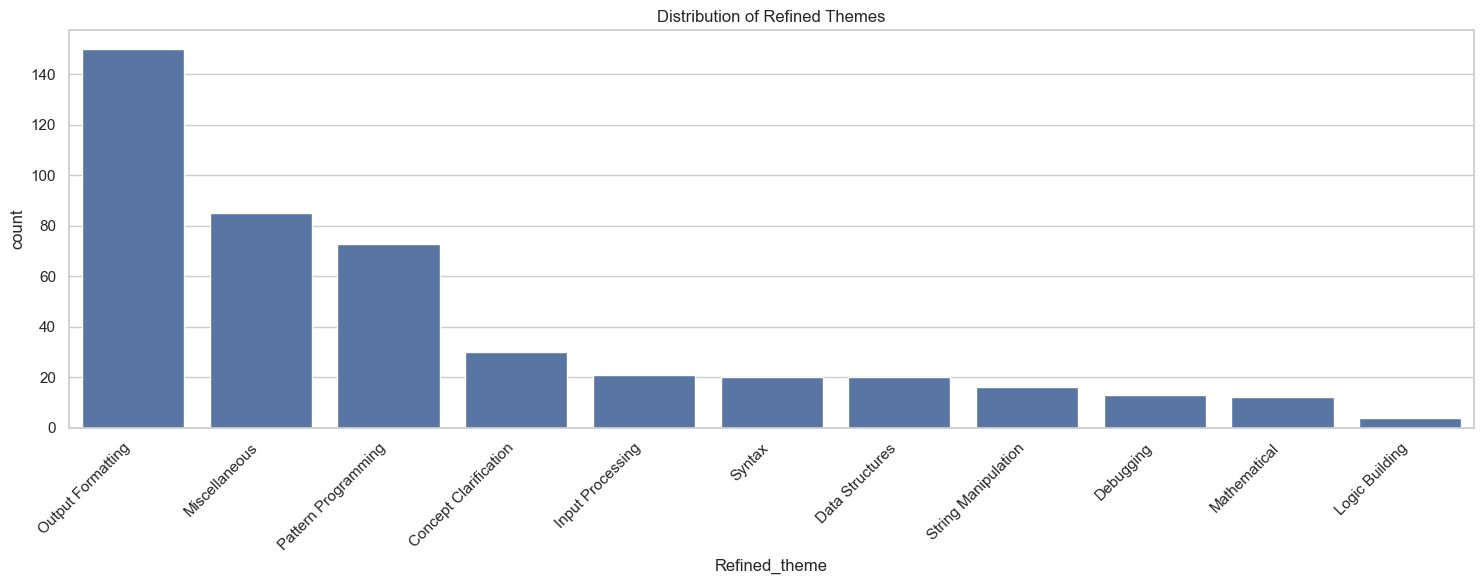

<Figure size 1500x800 with 0 Axes>

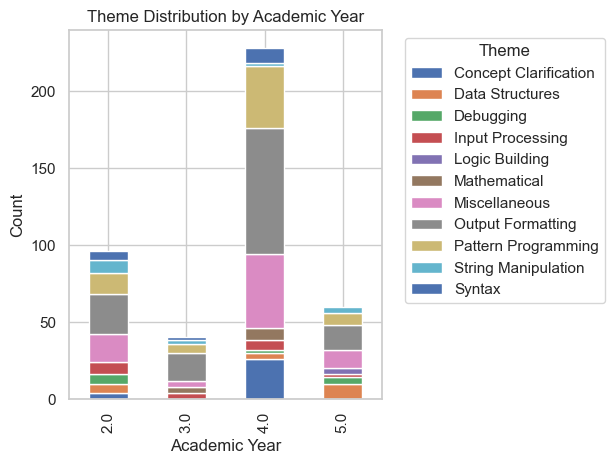

In [3]:
def create_refined_themes(data):
    """
    Refine theme categorization with more detailed subcategories
    """
    def identify_detailed_theme(row):
        prompt = str(row['Student_prompt']).lower()
        
        # Define subcategories with their keywords
        theme_keywords = {
            'Data Structures': ['array', 'list', 'stack', 'queue', 'tree', 'graph', 'dictionary', 'set'],
            'Algorithms': ['sort', 'search', 'algorithm', 'recursive', 'iteration'],
            'Syntax': ['syntax', 'variable', 'function', 'loop', 'condition', 'declare'],
            'Debugging': ['error', 'debug', 'fix', 'wrong', 'issue', 'problem'],
            'Pattern Programming': ['pattern', 'square', 'triangle', 'shape', 'print pattern', 'row', 'column', 
                                  'grid', 'matrix', 'paint', 'cells', 'white'],
            'Output Formatting': ['format', 'print', 'display', 'output', 'align', 'right', 'left', 'center',
                                'space', 'number format', 'decimal'],
            'Input Processing': ['input', 'read', 'parse', 'convert', 'validate', 'check input'],
            'Logic Building': ['logic', 'condition', 'if else', 'switch', 'case', 'boolean'],
            'String Manipulation': ['string', 'text', 'character', 'substring', 'concat', 'split'],
            'Mathematical': ['calculate', 'compute', 'sum', 'average', 'multiply', 'divide']
        }
        
        # Check for keywords in prompt
        matched_themes = []
        for theme, keywords in theme_keywords.items():
            if any(keyword in prompt for keyword in keywords):
                matched_themes.append(theme)
        
        # If multiple themes match, use additional context to determine primary theme
        if len(matched_themes) > 1:
            # Count keyword matches for each theme
            theme_scores = {}
            for theme in matched_themes:
                score = sum(1 for keyword in theme_keywords[theme] if keyword in prompt)
                theme_scores[theme] = score
            
            # Return theme with highest score
            return max(theme_scores.items(), key=lambda x: x[1])[0]
        
        # If one theme matches, return it
        elif len(matched_themes) == 1:
            return matched_themes[0]
        
        # If no predefined themes match, analyze content for categorization
        else:
            # Check for code modification patterns
            if any(word in prompt for word in ['modify', 'change', 'update', 'adjust']):
                return 'Code Modification'
            # Check for explanation requests
            elif any(word in prompt for word in ['explain', 'why', 'how', 'what', 'understand']):
                return 'Concept Clarification'
            # Check for optimization requests
            elif any(word in prompt for word in ['optimize', 'improve', 'better', 'faster']):
                return 'Optimization'
            else:
                return 'Miscellaneous'
    
    # Create new column with refined themes
    data['Refined_theme'] = data.apply(identify_detailed_theme, axis=1)
    
    # Calculate theme distribution
    theme_dist = data['Refined_theme'].value_counts()
    
    # Create transition matrix for refined themes
    transitions = pd.crosstab(
        data['Refined_theme'],
        data['Refined_theme'].shift(-1),
        normalize='index'
    )
    
    return {
        'data': data,
        'theme_distribution': theme_dist,
        'transitions': transitions
    }

def analyze_refined_themes(data_with_themes):
    """
    Analyze the refined theme categorization
    """
    # Basic distribution analysis
    theme_stats = pd.DataFrame({
        'count': data_with_themes['Refined_theme'].value_counts(),
        'percentage': data_with_themes['Refined_theme'].value_counts(normalize=True) * 100
    }).round(2)
    
    # Academic year analysis
    year_theme_dist = pd.crosstab(
        data_with_themes['ACYear'],
        data_with_themes['Refined_theme']
    )
    
    # Eye-tracking metrics by theme
    metrics = ['Fixation_count', 'Saccade_count', 'Dwell_time_gaze_ms']
    eye_tracking_stats = {}
    
    for metric in metrics:
        eye_tracking_stats[metric] = data_with_themes.groupby('Refined_theme')[metric].agg([
            'mean', 'std', 'count'
        ]).round(2)
    
    # Visualization of theme distribution
    plt.figure(figsize=(15, 6))
    sns.barplot(x=theme_stats.index, y='count', data=theme_stats)
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Refined Themes')
    plt.tight_layout()
    
    # Visualization of theme distribution by academic year
    plt.figure(figsize=(15, 8))
    year_theme_dist.plot(kind='bar', stacked=True)
    plt.title('Theme Distribution by Academic Year')
    plt.xlabel('Academic Year')
    plt.ylabel('Count')
    plt.legend(title='Theme', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    
    return {
        'theme_stats': theme_stats,
        'year_theme_dist': year_theme_dist,
        'eye_tracking_stats': eye_tracking_stats
    }

# Execute the analysis
refined_results = create_refined_themes(data)
analysis_results = analyze_refined_themes(refined_results['data'])

# Display results
print("\nTheme Distribution:")
print(analysis_results['theme_stats'])
print("\nTheme Distribution by Academic Year:")
print(analysis_results['year_theme_dist'])
print("\nEye-tracking Metrics by Theme:")
for metric, stats in analysis_results['eye_tracking_stats'].items():
    print(f"\n{metric}:")
    print(stats)

In [4]:
# Diagnostic function to check value ranges
def check_value_ranges(data):
    theme_metrics = data.groupby('Refined_theme').agg({
        'Fixation_count': ['mean', 'std', 'min', 'max'],
        'Saccade_count': ['mean', 'std', 'min', 'max'],
        'Dwell_time_gaze_ms': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("Value Ranges for Each Metric:")
    print("\nFixation Count:")
    print(theme_metrics['Fixation_count'])
    print("\nSaccade Count:")
    print(theme_metrics['Saccade_count'])
    print("\nDwell Time (ms):")
    print(theme_metrics['Dwell_time_gaze_ms'])

# Run diagnostic
check_value_ranges(data)

Value Ranges for Each Metric:

Fixation Count:
                         mean     std    min     max
Refined_theme                                       
Concept Clarification  511.77  290.32   76.0  1194.0
Data Structures        584.50  520.73  100.0  1636.0
Debugging              597.08  526.95  153.0  1636.0
Input Processing       396.50  373.61    8.0  1281.0
Logic Building         843.75  634.49   91.0  1635.0
Mathematical           300.17  216.35   70.0   865.0
Miscellaneous          470.04  380.12    8.0  1635.0
Output Formatting      359.44  253.70   12.0  1281.0
Pattern Programming    412.13  353.63   15.0  1636.0
String Manipulation    309.75  221.19   77.0   567.0
Syntax                 357.33  202.98   60.0   865.0

Saccade Count:
                          mean     std    min     max
Refined_theme                                        
Concept Clarification   648.53  340.61   82.0  1418.0
Data Structures         709.85  671.13   97.0  2141.0
Debugging               757.33  

## 2. Complexity Score Analysis and Statistical Reporting for Eye-Tracking Data

This section generates a comprehensive statistical report for eye-tracking data analysis in human-LLM programming interactions, with a particular focus on complexity score calculations and distributions. The analysis consists of three main components:

### 1. Complexity Score Calculation and Explanation
- Implements a normalized composite measure combining three eye-tracking metrics:
 - Fixation count
 - Saccade count
 - Dwell time
- Provides detailed explanation of the normalization process
- Includes practical examples with real data calculations
- Defines interpretation guidelines for different complexity levels

### 2. Sample Distribution Analysis
- Calculates and reports total interaction counts
- Breaks down sample sizes by dialogue themes
- Computes percentage distributions across categories
- Provides comprehensive theme-wise statistics

### 3. Theme Complexity Analysis
- Generates detailed complexity statistics for each theme including:
 - Mean and standard deviation
 - Minimum and maximum values
 - Distribution patterns
- Computes correlations between complexity scores and eye-tracking metrics
- Includes interpretation guidelines for complexity levels:
 - High complexity (> 1.2)
 - Medium complexity (0.8 - 1.2)
 - Low complexity (< 0.8)

The code serves as the statistical backbone for understanding cognitive load patterns in human-LLM programming interactions, providing both numerical analysis and interpretative frameworks.

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def identify_detailed_theme(row):
    prompt = str(row['Student_prompt']).lower()
    
    theme_keywords = {
        'Data Structures': ['array', 'list', 'stack', 'queue', 'tree', 'graph', 'dictionary', 'set'],
        'Algorithms': ['sort', 'search', 'algorithm', 'recursive', 'iteration'],
        'Syntax': ['syntax', 'variable', 'function', 'loop', 'condition', 'declare'],
        'Debugging': ['error', 'debug', 'fix', 'wrong', 'issue', 'problem'],
        'Pattern Programming': ['pattern', 'square', 'triangle', 'shape', 'print pattern', 'row', 'column', 
                              'grid', 'matrix', 'paint', 'cells', 'white'],
        'Output Formatting': ['format', 'print', 'display', 'output', 'align', 'right', 'left', 'center',
                            'space', 'number format', 'decimal'],
        'Input Processing': ['input', 'read', 'parse', 'convert', 'validate', 'check input'],
        'Logic Building': ['logic', 'condition', 'if else', 'switch', 'case', 'boolean'],
        'String Manipulation': ['string', 'text', 'character', 'substring', 'concat', 'split'],
        'Mathematical': ['calculate', 'compute', 'sum', 'average', 'multiply', 'divide']
    }
    
    matched_themes = []
    for theme, keywords in theme_keywords.items():
        if any(keyword in prompt for keyword in keywords):
            matched_themes.append(theme)
    
    if len(matched_themes) > 1:
        theme_scores = {}
        for theme in matched_themes:
            score = sum(1 for keyword in theme_keywords[theme] if keyword in prompt)
            theme_scores[theme] = score
        return max(theme_scores.items(), key=lambda x: x[1])[0]
    elif len(matched_themes) == 1:
        return matched_themes[0]
    else:
        if any(word in prompt for word in ['explain', 'why', 'how', 'what', 'understand']):
            return 'Concept Clarification'
        elif any(word in prompt for word in ['modify', 'change', 'update', 'adjust']):
            return 'Code Modification'
        else:
            return 'Miscellaneous'

def calculate_complexity_score(row):
    metrics = ['Fixation_count', 'Saccade_count', 'Dwell_time_gaze_ms']
    normalized_values = []
    
    for metric in metrics:
        mean_value = data[metric].mean()
        if mean_value != 0:
            normalized_values.append(row[metric] / mean_value)
    
    if normalized_values:
        return sum(normalized_values) / len(normalized_values)
    return 0

def generate_enhanced_statistical_report(data):
    print("="*80)
    print("COGNITIVE LOAD ANALYSIS IN STUDENT-CHATGPT PROGRAMMING INTERACTIONS")
    print("="*80)
    
    # 1. Sample and Distribution Analysis
    print("\n1. DESCRIPTIVE STATISTICS")
    print("-"*40)
    sample_sizes = data.groupby('Refined_theme').size()
    print(f"Total Interactions: N = {len(data)}")
    print(f"Number of Themes: {len(sample_sizes)}")
    
    theme_metrics = data.groupby('Refined_theme').agg({
        'Fixation_count': ['mean', 'std', 'count'],
        'Saccade_count': ['mean', 'std'],
        'Dwell_time_gaze_ms': ['mean', 'std'],
        'complexity_score': ['mean', 'std']
    }).round(2)
    
    # 2. Complexity Score Analysis
    print("\n2. COGNITIVE LOAD ANALYSIS")
    print("-"*40)
    print("\nTheme Complexity Categories:")
    
    high_complex = theme_metrics[theme_metrics['complexity_score']['mean'] > 1.2]
    med_complex = theme_metrics[(theme_metrics['complexity_score']['mean'] >= 0.8) & 
                              (theme_metrics['complexity_score']['mean'] <= 1.2)]
    low_complex = theme_metrics[theme_metrics['complexity_score']['mean'] < 0.8]
    
    print("\nHigh Cognitive Load Themes (> 1.2):")
    for idx in high_complex.index:
        print(f"- {idx}: M = {high_complex.loc[idx, ('complexity_score', 'mean')]:.2f}, "
              f"SD = {high_complex.loc[idx, ('complexity_score', 'std')]:.2f}, "
              f"n = {high_complex.loc[idx, ('Fixation_count', 'count')]}")
    
    print("\nMedium Cognitive Load Themes (0.8 - 1.2):")
    for idx in med_complex.index:
        print(f"- {idx}: M = {med_complex.loc[idx, ('complexity_score', 'mean')]:.2f}, "
              f"SD = {med_complex.loc[idx, ('complexity_score', 'std')]:.2f}, "
              f"n = {med_complex.loc[idx, ('Fixation_count', 'count')]}")
    
    print("\nLow Cognitive Load Themes (< 0.8):")
    for idx in low_complex.index:
        print(f"- {idx}: M = {low_complex.loc[idx, ('complexity_score', 'mean')]:.2f}, "
              f"SD = {low_complex.loc[idx, ('complexity_score', 'std')]:.2f}, "
              f"n = {low_complex.loc[idx, ('Fixation_count', 'count')]}")
    
    # 3. Eye-tracking Analysis
    print("\n3. EYE-TRACKING METRICS ANALYSIS")
    print("-"*40)
    metrics = ['Fixation_count', 'Saccade_count', 'Dwell_time_gaze_ms']
    
    for metric in metrics:
        groups = [group[metric].dropna() for name, group in data.groupby('Refined_theme')]
        f_stat, p_val = stats.f_oneway(*groups)
        
        groups_array = [np.array(group) for group in groups]
        ss_between = sum(len(group) * (np.mean(group) - np.mean(np.concatenate(groups_array)))**2 
                        for group in groups_array)
        ss_total = sum((np.concatenate(groups_array) - np.mean(np.concatenate(groups_array)))**2)
        eta_squared = ss_between / ss_total
        
        print(f"\n{metric.replace('_', ' ').title()}:")
        print(f"F({len(groups)-1}, {len(data)-len(groups)}) = {f_stat:.2f}, p = {p_val:.4f}, η² = {eta_squared:.3f}")
    
    # 4. Inter-metric Correlations
    print("\n4. METRIC CORRELATIONS")
    print("-"*40)
    correlation_matrix = data[metrics].corr()
    for i in range(len(metrics)-1):
        for j in range(i+1, len(metrics)):
            r = correlation_matrix.iloc[i,j]
            print(f"\n{metrics[i].replace('_', ' ')} vs {metrics[j].replace('_', ' ')}:")
            print(f"r = {r:.3f}")
    
    # 5. Summary of Key Findings
    print("\n5. KEY FINDINGS FOR REPORTING")
    print("-"*40)
    print("\nMost Notable Results:")
    print("1. Cognitive Load Differentiation:")
    print(f"   - Highest: {high_complex.index[0]} (M = {high_complex.iloc[0][('complexity_score', 'mean')]:.2f})")
    print(f"   - Lowest: {low_complex.index[-1]} (M = {low_complex.iloc[-1][('complexity_score', 'mean')]:.2f})")
    
    print("\n2. Theme Distribution:")
    most_common = sample_sizes.idxmax()
    print(f"   - Most common theme: {most_common} ({sample_sizes[most_common]} instances, {sample_sizes[most_common]/len(data)*100:.1f}%)")
    
    dwell_means = data.groupby('Refined_theme')['Dwell_time_gaze_ms'].mean()
    highest_dwell = dwell_means.idxmax()
    print(f"\n3. Engagement Metrics:")
    print(f"   - Highest average dwell time: {highest_dwell} ({dwell_means[highest_dwell]/1000:.1f} seconds)")
    
    return {
        'theme_metrics': theme_metrics,
        'correlation_matrix': correlation_matrix,
        'sample_sizes': sample_sizes,
        'complexity_categories': {
            'high': high_complex,
            'medium': med_complex,
            'low': low_complex
        }
    }

# Load data
file_path = '/Users/mts517/Desktop/NLP Analysis/Joined_Dataset.csv'  # Update with your path
data = pd.read_csv(file_path)

# Prepare data
data['Refined_theme'] = data.apply(identify_detailed_theme, axis=1)
data['complexity_score'] = data.apply(calculate_complexity_score, axis=1)

# Run analysis
results = generate_enhanced_statistical_report(data)

# Verification output
print("\nVerification of new columns:")
print("\nUnique themes found:")
print(data['Refined_theme'].value_counts())
print("\nComplexity score range:")
print(f"Min: {data['complexity_score'].min():.2f}")
print(f"Max: {data['complexity_score'].max():.2f}")
print(f"Mean: {data['complexity_score'].mean():.2f}")

COGNITIVE LOAD ANALYSIS IN STUDENT-CHATGPT PROGRAMMING INTERACTIONS

1. DESCRIPTIVE STATISTICS
----------------------------------------
Total Interactions: N = 444
Number of Themes: 11

2. COGNITIVE LOAD ANALYSIS
----------------------------------------

Theme Complexity Categories:

High Cognitive Load Themes (> 1.2):
- Data Structures: M = 1.41, SD = 1.21, n = 20
- Debugging: M = 1.39, SD = 1.25, n = 12
- Logic Building: M = 1.91, SD = 1.44, n = 4

Medium Cognitive Load Themes (0.8 - 1.2):
- Concept Clarification: M = 1.20, SD = 0.67, n = 30
- Input Processing: M = 0.93, SD = 0.86, n = 20
- Miscellaneous: M = 1.09, SD = 0.86, n = 82
- Output Formatting: M = 0.86, SD = 0.62, n = 142
- Pattern Programming: M = 0.97, SD = 0.82, n = 68
- String Manipulation: M = 0.92, SD = 0.73, n = 16
- Syntax: M = 0.91, SD = 0.58, n = 18

Low Cognitive Load Themes (< 0.8):
- Mathematical: M = 0.69, SD = 0.50, n = 12

3. EYE-TRACKING METRICS ANALYSIS
----------------------------------------

Fixation Co

In [12]:
def generate_statistical_report(data):
    from scipy import stats
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    from statsmodels.stats.multicomp import MultiComparison
    
    # [Previous initial data status code remains the same until metrics analysis]
    
    # 3. Eye-tracking Metrics Analysis
    print("\n3. EYE-TRACKING METRICS")
    print("-"*40)
    metrics = ['Fixation_count', 'Saccade_count', 'Dwell_time_gaze_ms']
    
    for metric in metrics:
        print(f"\n{metric.replace('_', ' ').title()}:")
        
        # Prepare data for analysis
        model_data = data[['Refined_theme', metric]].dropna()
        
        try:
            # One-way ANOVA with Bonferroni correction
            groups_dict = {name: group[metric].dropna().values 
                         for name, group in data.groupby('Refined_theme')}
            groups_dict = {k: v for k, v in groups_dict.items() if len(v) > 0}
            groups = list(groups_dict.values())
            
            # Calculate basic ANOVA
            f_stat, p_val = stats.f_oneway(*groups)
            
            # Multiple comparisons with Bonferroni correction
            mc = MultiComparison(model_data[metric], model_data['Refined_theme'])
            bonf_results = mc.allpairtest(stats.ttest_ind, method='bonf')
            
            # Calculate effect sizes
            groups_array = [np.array(group) for group in groups]
            ss_between = sum(len(group) * (np.mean(group) - np.mean(np.concatenate(groups_array)))**2 
                           for group in groups_array)
            ss_total = sum((np.concatenate(groups_array) - np.mean(np.concatenate(groups_array)))**2)
            eta_squared = ss_between / ss_total
            
            # Report results
            df_between = len(groups) - 1
            df_within = len(np.concatenate(groups_array)) - len(groups)
            print(f"\nOne-way ANOVA: F({df_between}, {df_within}) = {f_stat:.3f}, p = {p_val:.4f}")
            print(f"Effect size (η²) = {eta_squared:.3f}")
            
            # Print significant comparisons after Bonferroni correction
            print("\nSignificant theme comparisons (Bonferroni-corrected):")
            significant_pairs = []
            for row in bonf_results[0].data:
                if row[3] < 0.05:  # Corrected p-value
                    significant_pairs.append(f"{row[0]} vs {row[1]}: p = {row[3]:.4f}")
            
            if significant_pairs:
                for pair in significant_pairs:
                    print(pair)
            else:
                print("No significant differences found after correction")
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")

    # 4. Correlation Analysis with Spearman and Bonferroni correction
    print("\n4. CORRELATION ANALYSIS")
    print("-"*40)
    
    complete_data = data[metrics].dropna()
    print(f"\nCorrelation analysis based on {len(complete_data)} complete cases")
    print(f"Removed cases due to NA: {len(data) - len(complete_data)}")
    
    # Spearman correlation with Bonferroni correction
    n_comparisons = (len(metrics) * (len(metrics) - 1)) // 2
    alpha_corrected = 0.05 / n_comparisons
    
    print(f"\nSpearman correlations (Bonferroni-corrected α = {alpha_corrected:.4f}):")
    for i in range(len(metrics)):
        for j in range(i+1, len(metrics)):
            r, p = stats.spearmanr(complete_data[metrics[i]], 
                                 complete_data[metrics[j]], 
                                 nan_policy='omit')
            print(f"\n{metrics[i]} vs {metrics[j]}:")
            print(f"rho = {r:.3f}, p = {p:.4f}")
            print(f"Significant: {p < alpha_corrected}")
    
    # Add readability metrics
    print("\n5. READABILITY METRICS")
    print("-"*40)
    
    try:
        from textstat import textstat
        
        # Assuming there's a 'dialogue_text' column in your data
        # If not, adjust according to your actual text column
        if 'dialogue_text' in data.columns:
            print("\nReadability scores:")
            flesch = data['dialogue_text'].apply(textstat.flesch_reading_ease).mean()
            smog = data['dialogue_text'].apply(textstat.smog_index).mean()
            
            print(f"Average Flesch Reading Ease: {flesch:.2f}")
            print(f"Average SMOG Index: {smog:.2f}")
        else:
            print("Note: Text column not found for readability analysis")
            
    except ImportError:
        print("Note: textstat package not installed for readability metrics")
    
    # [Rest of the reporting recommendations code remains the same]

# Generate the statistical report
generate_statistical_report(data)


3. EYE-TRACKING METRICS
----------------------------------------

Fixation Count:

One-way ANOVA: F(10, 413) = 2.777, p = 0.0025
Effect size (η²) = 0.063

Significant theme comparisons (Bonferroni-corrected):
Error in analysis: '<' not supported between instances of 'str' and 'float'

Saccade Count:

One-way ANOVA: F(10, 413) = 2.068, p = 0.0259
Effect size (η²) = 0.048

Significant theme comparisons (Bonferroni-corrected):
Error in analysis: '<' not supported between instances of 'str' and 'float'

Dwell Time Gaze Ms:

One-way ANOVA: F(10, 413) = 2.522, p = 0.0059
Effect size (η²) = 0.058

Significant theme comparisons (Bonferroni-corrected):
Error in analysis: '<' not supported between instances of 'str' and 'float'

4. CORRELATION ANALYSIS
----------------------------------------

Correlation analysis based on 424 complete cases
Removed cases due to NA: 20

Spearman correlations (Bonferroni-corrected α = 0.0167):

Fixation_count vs Saccade_count:
rho = 0.954, p = 0.0000
Significant